## Environment set up and import Libraries

In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
with tf.device(device_name):
  print(device_name.split(":")[1]," running . . . ")

GPU  running . . . 


In [1]:
import tensorflow as tf
import os,sys
import numpy as np
import random

random.seed(1)
np.random.seed(1)
tf.random.set_seed(2)

In [2]:
import os, keras, numpy
import matplotlib.pyplot as plt
from numpy import *
from numpy.random import *
from keras.datasets.fashion_mnist import load_data
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import *

## **Discriminator** Model

In [102]:
def define_discriminator(in_shape=(64,64,3)):

    # input image
    input_image = Input(shape=in_shape)
    # (64, 64, 3)

    conv2d_layer_1 = Conv2D(filters = 16, kernel_size = (3,3), strides = (2,2), padding='same')(input_image)
    conv2d_layer_1 = LeakyReLU(alpha=0.3)(conv2d_layer_1)
    # (32, 32, 16)

    conv2d_layer_2 = Conv2D(filters = 32, kernel_size = (3,3), strides = (2,2), padding = 'same')(conv2d_layer_1)
    conv2d_layer_2 = LeakyReLU(alpha=0.3)(conv2d_layer_2)
    # (16, 16, 32)

    conv2d_layer_3 = Conv2D(filters = 64, kernel_size = (3,3),  strides = (2,2), padding = 'same')(conv2d_layer_2)
    conv2d_layer_3 = LeakyReLU(alpha=0.3)(conv2d_layer_3)
    # (8, 8, 64)

    conv2d_layer_4 = Conv2D(filters = 128, kernel_size = (3,3), strides = (2,2), padding = 'same')(conv2d_layer_3)
    conv2d_layer_4 = LeakyReLU(alpha=0.3)(conv2d_layer_4)
    # (4, 4, 128)

    flatten_layer = Flatten()(conv2d_layer_4)
    # (4 * 4 * 128)

    dense_layer = Dense(128*8, activation='relu')(flatten_layer)
    # (8 * 128)

    # final layer
    output_layer = Dense(1, activation='sigmoid')(dense_layer)
    # (1,)

    model = Model(input_image, output_layer)

    opt = Adam(learning_rate= 3e-4, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

a = define_discriminator()
a.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_64 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 leaky_re_lu_56 (LeakyReLU)  (None, 32, 32, 16)        0         
                                                                 
 conv2d_65 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 leaky_re_lu_57 (LeakyReLU)  (None, 16, 16, 32)        0         
                                                                 
 conv2d_66 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 leaky_re_lu_58 (LeakyReLU)  (None, 8, 8, 64)          0  

In [103]:
# plot the discriminator model
# tf.keras.utils.plot_model(a)

## **Generator** Model

In [104]:
def define_generator(latent_dim = 100):

    # latent input
    latent_layer = Input(shape=(latent_dim,))
    layer_1 = Dense(128 * 8 * 8)(latent_layer)
    layer_2 = Reshape((8, 8, 128))(layer_1)
    # (8, 8, 128)

    layer_3 = Conv2DTranspose(filters = 128, kernel_size = (3,3), strides=(2,2), padding='same')(layer_2)
    layer_3 = Conv2D(filters = 128, kernel_size = (3,3), padding='same')(layer_3)
    layer_3 = LeakyReLU(alpha=0.2)(layer_3)
    # (16, 16, 128)

    layer_4 = Conv2DTranspose(filters = 128, kernel_size = (3,3), strides=(2,2), padding='same')(layer_3)
    layer_4 = Conv2D(filters = 64, kernel_size = (3,3), padding='same')(layer_4)
    layer_4 = LeakyReLU(alpha=0.2)(layer_4)
    # (32, 32, 128)

    layer_5 = Conv2DTranspose(filters = 128, kernel_size = (3,3), strides=(2,2), padding='same')(layer_4)
    layer_5 = Conv2D(filters = 64, kernel_size = (3,3), padding='same')(layer_5)
    layer_5 = LeakyReLU(alpha=0.2)(layer_5)
    # (64, 64, 128)

    # final layer
    output_layer = Conv2D(filters = 3, kernel_size = (3,3), strides=(1,1), activation='tanh', padding='same')(layer_5)

    model = Model(latent_layer, output_layer)
    return model

b = define_generator(100)
b.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_26 (Dense)            (None, 8192)              827392    
                                                                 
 reshape_8 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_24 (Conv2D  (None, 16, 16, 128)      147584    
 Transpose)                                                      
                                                                 
 conv2d_68 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 leaky_re_lu_60 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                          

In [105]:
# plot the generator model
# tf.keras.utils.plot_model(b)

## **Combine** or **GAN** Model

In [106]:
def define_gan(g_model, d_model):

  d_model.trainable = False

  g_noise = g_model.input
  g_output = g_model.output

  d_output = d_model(g_output)

  model = Model(g_noise, d_output)

  opt = Adam(learning_rate= 3e-4, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt,  metrics=['accuracy'])
  
  return model
# c = define_gan(b, a)
# c.summary()

In [107]:
# plot GAN model
# tf.keras.utils.plot_model(c)

## Load Dataset

In [108]:
def load_real_samples():
  # load dataset
  data = np.load("/content/drive/MyDrive/Animo/DataSet1/animo_file_10000.npz")
  data = data['a']
  data = np.array(data)
  # expand to 3d, e.g. add channels
  # X = expand_dims(trainX, axis=-1)
  X = data.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return X
# k = load_real_samples()
# print("image: ",k.shape)
# print("\nshape/size of the first 16 data: ",k[:16].shape)

## Plot data with label

## Plot data with label

In [109]:
def save_plot(x_input,n=4):
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.imshow(x_input[i,:,:,:])
        plt.axis('off')
    plt.show()
# plot data
# save_plot(k[:16])

## Generate real sample function

In [110]:
def generate_real_samples(dataset, n_samples):
	images = dataset
	ix = randint(0, images.shape[0], n_samples)
	X = images[ix]
	y = ones((n_samples, 1))
	return X, y
# d = generate_real_samples(k, 32)
# print("Generate real data as a batch randomly: ",d[0][0].shape)

## Generate latent point function

In [111]:
def generate_latent_points(latent_dim, n_samples, n_classes=2):
  x_input = randn(latent_dim * n_samples)
  z_input = x_input.reshape(n_samples, latent_dim)
  return z_input
# p = generate_latent_points(100, 32)
# print("Generate latent point(with label) as a batch: ",p.shape)

## Generate Fake samples of image with label

In [112]:
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict(z_input)
	y = zeros((n_samples, 1))
	return images, y
# with tf.device(device_name):
# 	kh = generate_fake_samples(b, 100, 32)
# 	print("shape of the generated images: ",kh[0].shape)

## Summarize the generator model

In [113]:
def summarize_the_model(generator,latent_dim = 100):
    latent_points = generate_latent_points(latent_dim= latent_dim, n_samples= 16)
    X  = generator.predict(latent_points)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    save_plot(X, n=4)

## Train function

In [114]:
def train(g_model, d_model, gan_model, dataset, latent_dim= 100, n_epochs=3, n_batch=16):

  print("\nNo. of epoch: ",n_epochs)
  bat_per_epo = int(dataset.shape[0] / n_batch)
  print("\nbatch per epoch: ", bat_per_epo)
  half_batch = int(n_batch / 2)
  print("\nfull batch: ", n_batch)
  print("\nhalf batch: ", half_batch,'\n')
  print("*"*50,'\n\n')

  d_loss_real_array,d_loss_fake_array =[],[]
  g_loss_array = []
  for i in range(n_epochs):
    d_loss_r,d_loss_f = 0.0,0.0
    g_loss = 0.0
    
    for j in range(bat_per_epo):

      X_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)
      d_loss_r += d_loss1
      # print("d-real\n")

      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
      d_loss_f += d_loss2
      # print("d-fake\n")

      z_input = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))
      g_loss1,_ = gan_model.train_on_batch(z_input, y_gan)
      g_loss += g_loss1
      # print("g-loss\n")

    d_loss_real_array.append(d_loss_r)
    d_loss_fake_array.append(d_loss_f)
    g_loss_array.append(g_loss)

    print('epoch -> [%d/%d], discriminator_loss_for_real_data = %.2f, discriminator_loss_for_fake_data = %.2f, generator_loss = %.2f\n' %(i+1, n_epochs, d_loss_r, d_loss_f, g_loss))
    summarize_the_model(g_model,latent_dim)
    # g_model.save("g_gan_model_"+str(i)+".h5")
    g_model.save("/content/drive/MyDrive/Animo/DataSet1/generator_model1242.h5")
    np.savez_compressed('/content/drive/MyDrive/Animo/DataSet1/loss_record1242.npz', a=d_loss_real_array, b=d_loss_fake_array, c=g_loss_array)

    print("\n")

  return d_loss_real_array, d_loss_fake_array, g_loss_array

## Main function


READY TO GO !!!


No. of epoch:  50

batch per epoch:  312

full batch:  32

half batch:  16 

************************************************** 


epoch -> [1/50], discriminator_loss_for_real_data = 130.38, discriminator_loss_for_fake_data = 155.88, generator_loss = 648.05



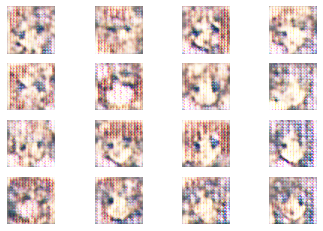



epoch -> [2/50], discriminator_loss_for_real_data = 209.50, discriminator_loss_for_fake_data = 207.40, generator_loss = 273.76



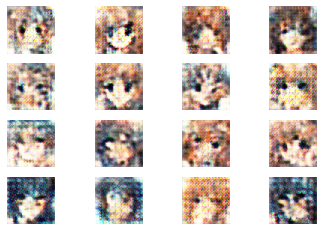



epoch -> [3/50], discriminator_loss_for_real_data = 212.00, discriminator_loss_for_fake_data = 212.77, generator_loss = 236.19



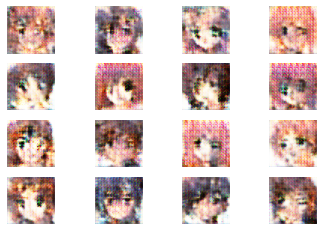



epoch -> [4/50], discriminator_loss_for_real_data = 211.91, discriminator_loss_for_fake_data = 212.98, generator_loss = 233.05



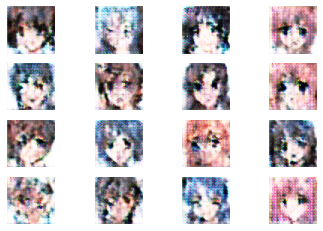



epoch -> [5/50], discriminator_loss_for_real_data = 209.79, discriminator_loss_for_fake_data = 212.70, generator_loss = 238.32



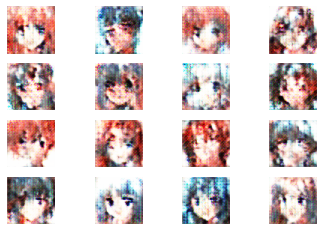



epoch -> [6/50], discriminator_loss_for_real_data = 206.11, discriminator_loss_for_fake_data = 213.50, generator_loss = 247.46



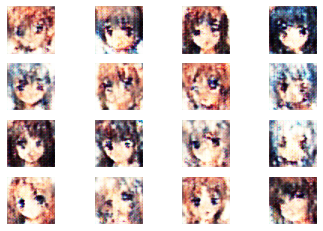



epoch -> [7/50], discriminator_loss_for_real_data = 190.08, discriminator_loss_for_fake_data = 207.57, generator_loss = 298.66



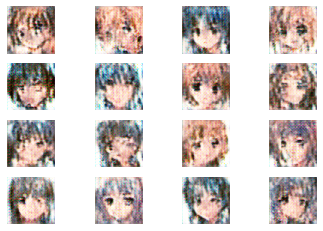



epoch -> [8/50], discriminator_loss_for_real_data = 200.77, discriminator_loss_for_fake_data = 209.57, generator_loss = 257.89



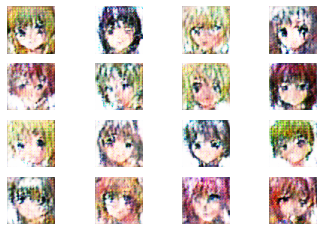



epoch -> [9/50], discriminator_loss_for_real_data = 202.69, discriminator_loss_for_fake_data = 209.94, generator_loss = 254.72



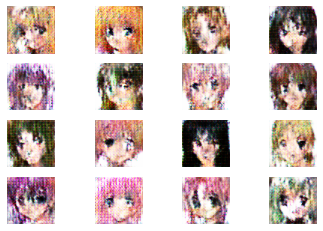



epoch -> [10/50], discriminator_loss_for_real_data = 201.38, discriminator_loss_for_fake_data = 209.88, generator_loss = 255.72



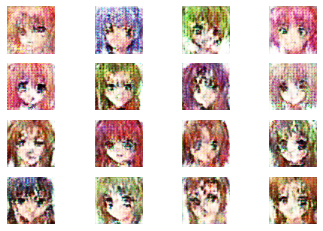



epoch -> [11/50], discriminator_loss_for_real_data = 199.49, discriminator_loss_for_fake_data = 208.70, generator_loss = 257.48



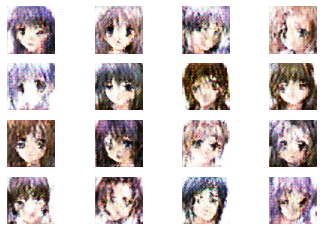



epoch -> [12/50], discriminator_loss_for_real_data = 195.07, discriminator_loss_for_fake_data = 206.98, generator_loss = 266.07



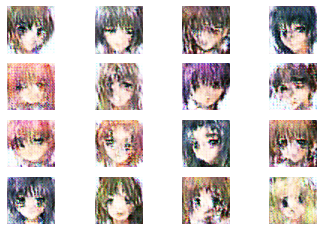



epoch -> [13/50], discriminator_loss_for_real_data = 185.85, discriminator_loss_for_fake_data = 200.52, generator_loss = 287.58



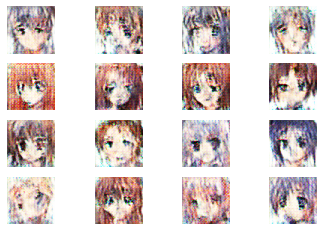



epoch -> [14/50], discriminator_loss_for_real_data = 177.26, discriminator_loss_for_fake_data = 195.28, generator_loss = 300.75



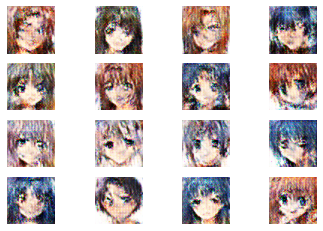



epoch -> [15/50], discriminator_loss_for_real_data = 171.89, discriminator_loss_for_fake_data = 189.33, generator_loss = 321.12



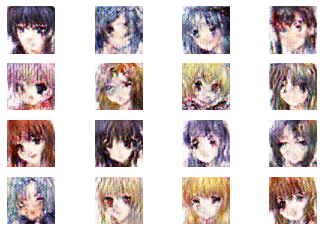



epoch -> [16/50], discriminator_loss_for_real_data = 163.86, discriminator_loss_for_fake_data = 176.28, generator_loss = 353.22



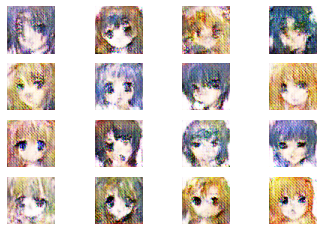



epoch -> [17/50], discriminator_loss_for_real_data = 151.67, discriminator_loss_for_fake_data = 163.54, generator_loss = 392.13



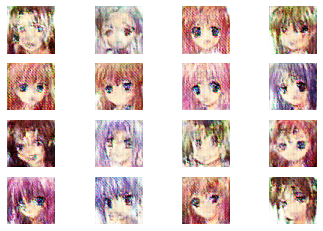



epoch -> [18/50], discriminator_loss_for_real_data = 145.54, discriminator_loss_for_fake_data = 152.74, generator_loss = 422.23



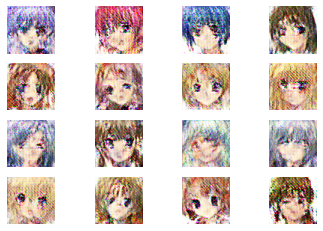



epoch -> [19/50], discriminator_loss_for_real_data = 137.68, discriminator_loss_for_fake_data = 142.70, generator_loss = 461.22



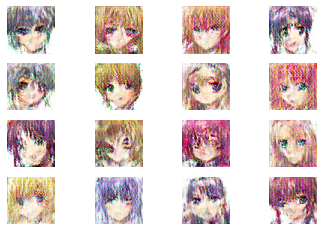



epoch -> [20/50], discriminator_loss_for_real_data = 129.78, discriminator_loss_for_fake_data = 133.35, generator_loss = 503.37



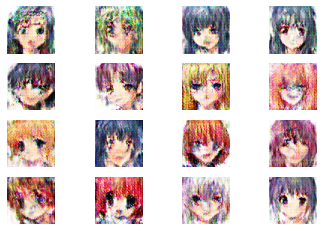



epoch -> [21/50], discriminator_loss_for_real_data = 117.09, discriminator_loss_for_fake_data = 120.25, generator_loss = 560.58



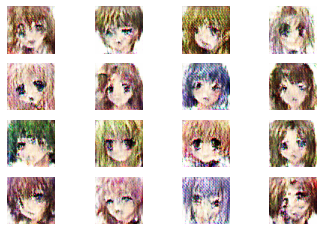



epoch -> [22/50], discriminator_loss_for_real_data = 107.38, discriminator_loss_for_fake_data = 111.06, generator_loss = 595.83



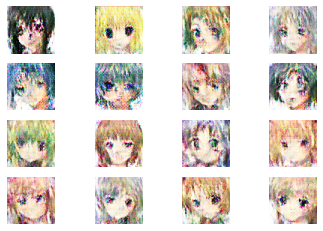



epoch -> [23/50], discriminator_loss_for_real_data = 102.73, discriminator_loss_for_fake_data = 104.67, generator_loss = 645.91



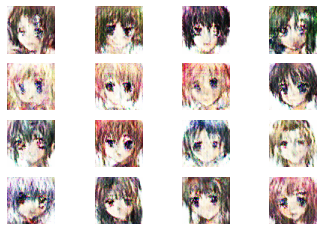



epoch -> [24/50], discriminator_loss_for_real_data = 92.30, discriminator_loss_for_fake_data = 95.63, generator_loss = 710.47



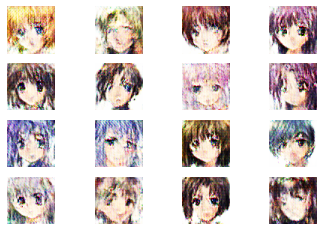



epoch -> [25/50], discriminator_loss_for_real_data = 87.07, discriminator_loss_for_fake_data = 89.64, generator_loss = 755.83



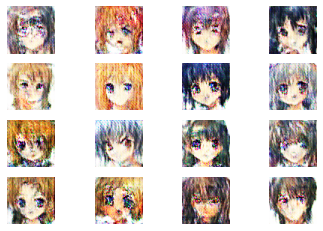



epoch -> [26/50], discriminator_loss_for_real_data = 80.58, discriminator_loss_for_fake_data = 82.52, generator_loss = 804.80



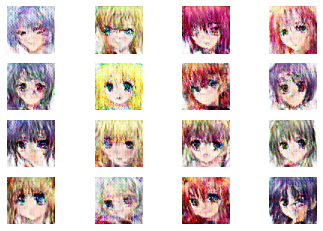



epoch -> [27/50], discriminator_loss_for_real_data = 75.56, discriminator_loss_for_fake_data = 80.62, generator_loss = 855.48



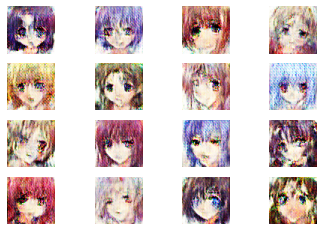



epoch -> [28/50], discriminator_loss_for_real_data = 70.69, discriminator_loss_for_fake_data = 74.48, generator_loss = 887.22



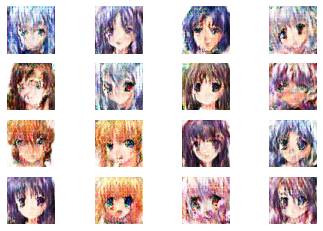



epoch -> [29/50], discriminator_loss_for_real_data = 63.50, discriminator_loss_for_fake_data = 69.63, generator_loss = 928.11



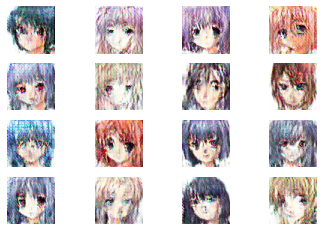



epoch -> [30/50], discriminator_loss_for_real_data = 62.78, discriminator_loss_for_fake_data = 67.55, generator_loss = 971.61



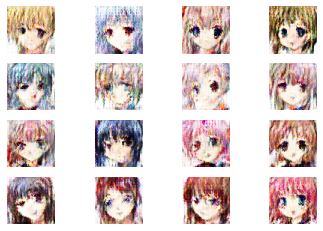



epoch -> [31/50], discriminator_loss_for_real_data = 60.19, discriminator_loss_for_fake_data = 64.67, generator_loss = 1002.69



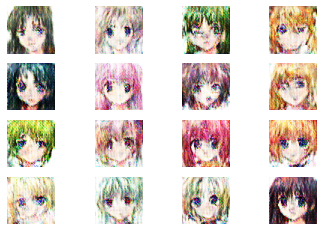



epoch -> [32/50], discriminator_loss_for_real_data = 59.35, discriminator_loss_for_fake_data = 63.16, generator_loss = 1040.68



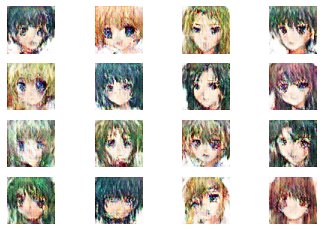



epoch -> [33/50], discriminator_loss_for_real_data = 56.50, discriminator_loss_for_fake_data = 62.08, generator_loss = 1072.43



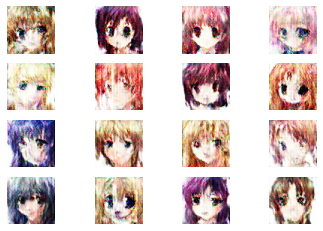



epoch -> [34/50], discriminator_loss_for_real_data = 54.39, discriminator_loss_for_fake_data = 58.60, generator_loss = 1111.45



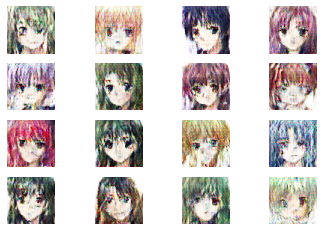



epoch -> [35/50], discriminator_loss_for_real_data = 52.34, discriminator_loss_for_fake_data = 55.67, generator_loss = 1136.20



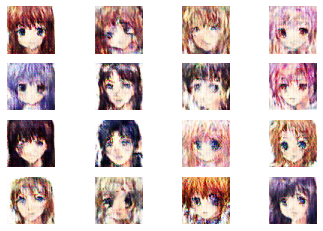



epoch -> [36/50], discriminator_loss_for_real_data = 44.72, discriminator_loss_for_fake_data = 49.56, generator_loss = 1206.57



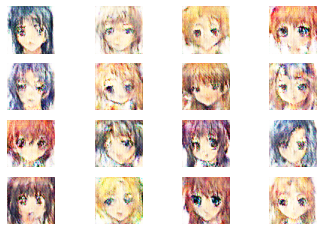



epoch -> [37/50], discriminator_loss_for_real_data = 44.83, discriminator_loss_for_fake_data = 50.29, generator_loss = 1242.09



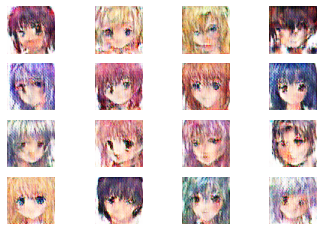



epoch -> [38/50], discriminator_loss_for_real_data = 44.76, discriminator_loss_for_fake_data = 52.15, generator_loss = 1255.66



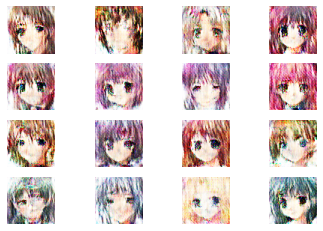



epoch -> [39/50], discriminator_loss_for_real_data = 44.74, discriminator_loss_for_fake_data = 49.82, generator_loss = 1313.56



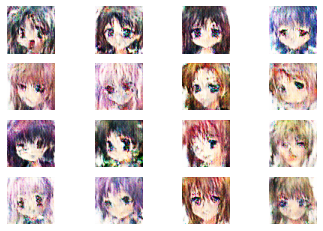



epoch -> [40/50], discriminator_loss_for_real_data = 41.79, discriminator_loss_for_fake_data = 46.97, generator_loss = 1321.31



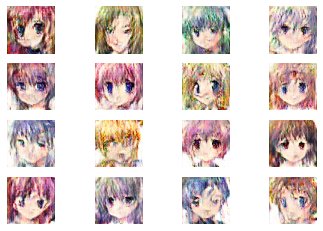



epoch -> [41/50], discriminator_loss_for_real_data = 35.67, discriminator_loss_for_fake_data = 42.47, generator_loss = 1356.23



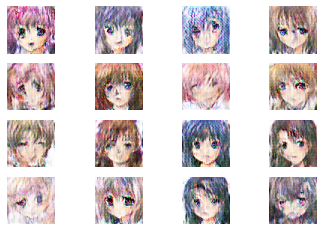



epoch -> [42/50], discriminator_loss_for_real_data = 38.58, discriminator_loss_for_fake_data = 43.24, generator_loss = 1390.60



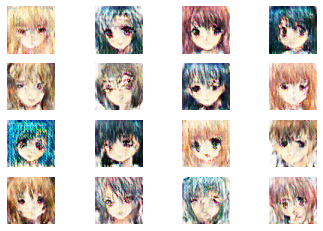



epoch -> [43/50], discriminator_loss_for_real_data = 36.67, discriminator_loss_for_fake_data = 43.17, generator_loss = 1411.73



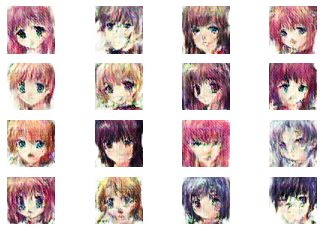



epoch -> [44/50], discriminator_loss_for_real_data = 36.28, discriminator_loss_for_fake_data = 41.25, generator_loss = 1463.47



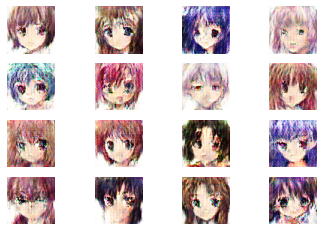



epoch -> [45/50], discriminator_loss_for_real_data = 36.91, discriminator_loss_for_fake_data = 41.97, generator_loss = 1447.29



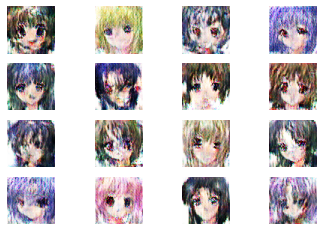



epoch -> [46/50], discriminator_loss_for_real_data = 35.01, discriminator_loss_for_fake_data = 41.49, generator_loss = 1445.02



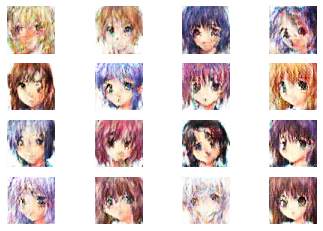



epoch -> [47/50], discriminator_loss_for_real_data = 38.82, discriminator_loss_for_fake_data = 46.72, generator_loss = 1494.29



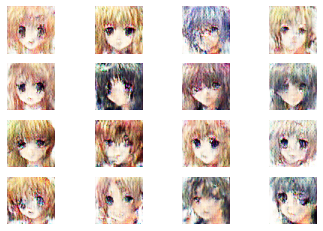



epoch -> [48/50], discriminator_loss_for_real_data = 33.10, discriminator_loss_for_fake_data = 39.11, generator_loss = 1504.12



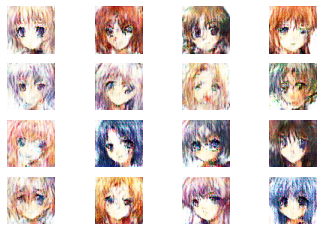



epoch -> [49/50], discriminator_loss_for_real_data = 35.44, discriminator_loss_for_fake_data = 43.31, generator_loss = 1542.20



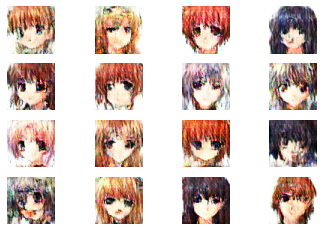



epoch -> [50/50], discriminator_loss_for_real_data = 34.09, discriminator_loss_for_fake_data = 39.96, generator_loss = 1523.83



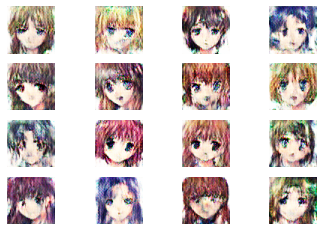

In [115]:
with tf.device(device_name):

  latent_dim = 512
  n_epochs = 50
  n_batch = 32
  d_model = define_discriminator()
  g_model = define_generator(latent_dim)
  gan_model = define_gan(g_model, d_model)
  dataset = load_real_samples()
  print('\nREADY TO GO !!!\n')
  
  d_loss_r, d_loss_f, g_loss = train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch)

## Plot Loss Values

In [116]:
loaded = np.load('/content/drive/MyDrive/Animo/DataSet1/loss_record1242.npz')
print(loaded['a'].shape)
print(loaded['b'].shape)
print(loaded['c'].shape)

(50,)
(50,)
(50,)


In [117]:
import matplotlib.pyplot as plot

g_loss = np.array(loaded['c'])

In [118]:
d_loss = np.array([(i+j) for i,j in zip(loaded['a'], loaded['b'])])

In [119]:
# print(d_loss_r)
# print(d_loss_f)
# print(d_loss)
# print(g_loss)

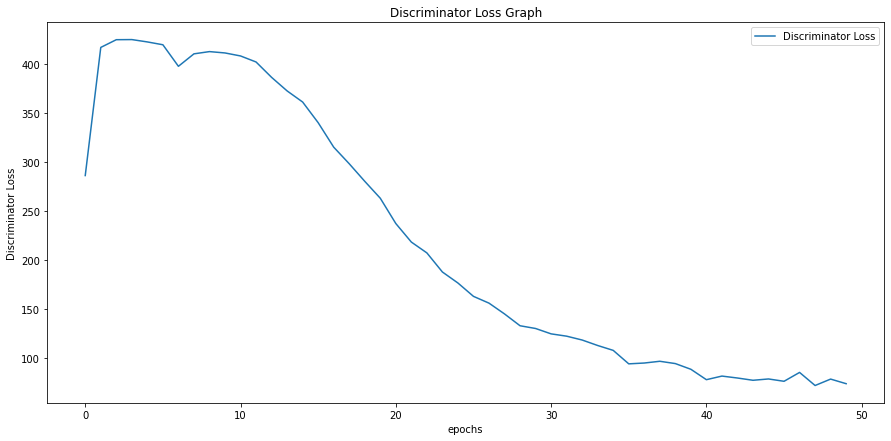

In [120]:
plt.figure(figsize=(15,7))
plt.plot(d_loss)
plt.title('Discriminator Loss Graph')
plt.ylabel('Discriminator Loss')
plt.xlabel('epochs')
plt.legend(["Discriminator Loss"], loc='upper right')
plt.show()

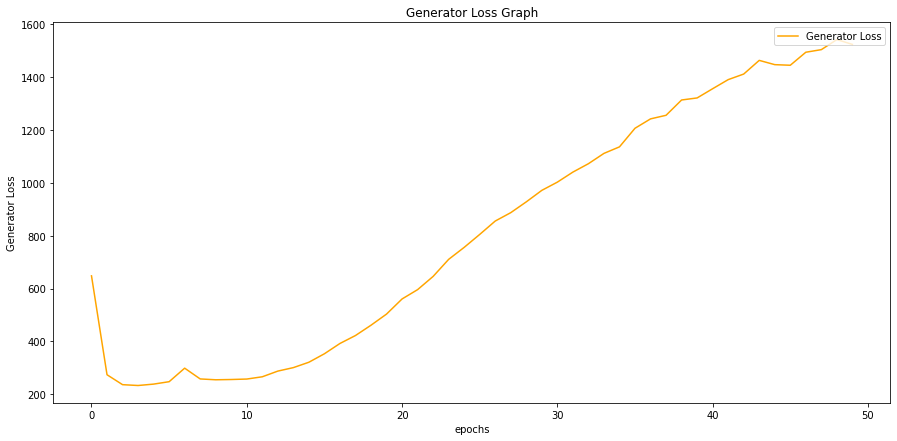

In [121]:
plt.figure(figsize=(15,7))
plt.plot(g_loss,color='orange')
plt.title('Generator Loss Graph')
plt.ylabel('Generator Loss')
plt.xlabel('epochs')
plt.legend(["Generator Loss"], loc='upper right')
plt.show()

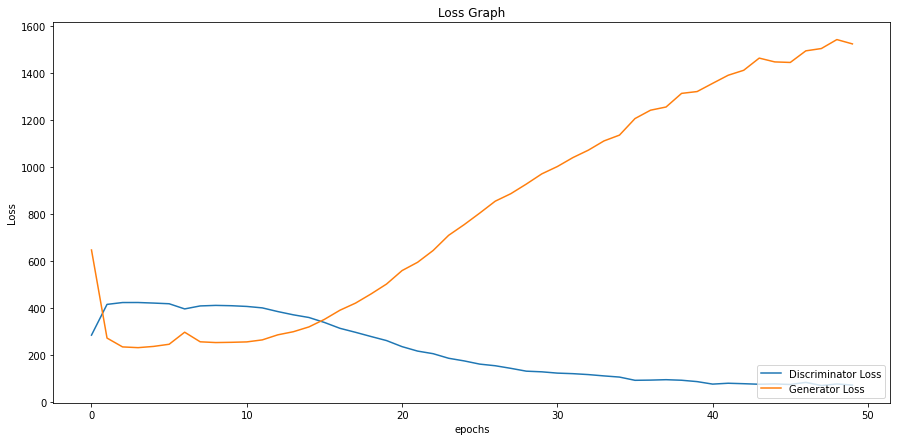

In [122]:
plt.figure(figsize=(15,7))
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Loss Graph')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(["Discriminator Loss", "Generator Loss"], loc='lower right')
plt.show()

                                              -:END:-